In [2]:
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import scipy.integrate as spi
import scipy.optimize as opt

In [13]:
dates_ebola = []
countries_ebola = []
with open('ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [14]:
def convert_date_to_number(date, earliest_date):
    """convert dates to numbers

    Args:
        date (str): String of a date, it should be in format "%d/%m/%Y" 
        earliest_date (str, optional): Date that has value 0. Defaults to "01/01/2011".

    Returns:
        int: Number of days after the earliest_date
    """
    date_format = "%d/%m/%Y" 
    delta = datetime.strptime(date, date_format) - datetime.strptime(earliest_date, date_format) 
    return delta.days + 1

date_nums_guinea = [convert_date_to_number(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_number(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_number(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_number(date, dates_all[0]) for date in dates_all]

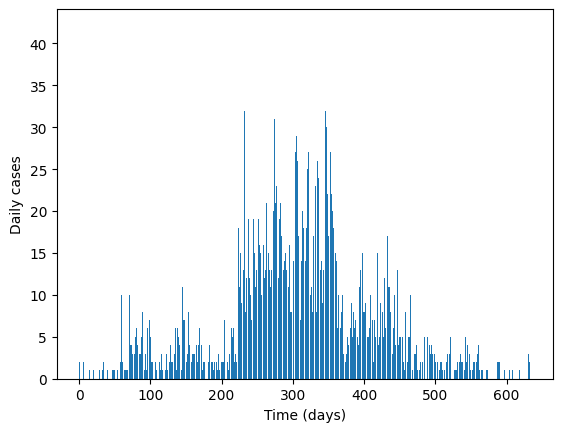

In [15]:
def daily_frequency(event_times):
    counter = Counter(event_times)
    keys = counter.keys()
    values = [counter[key] for key in keys]
    plt.bar(keys, values)
    plt.xlabel('Time (days)')
    plt.ylabel('Daily cases')

daily_frequency(date_nums_guinea)


In [16]:
def distribute(data):
    """Distribute cases in the same day evenly

    Args:
        data (List(int)): A list of event times

    Returns:
        List: Distributed event times
    """
    counter = Counter(data)
    sorted_elements = sorted(counter.keys())
    time_ticks = []
    for e in sorted_elements:
        count = counter[e]
        for n in range(count):
            time_ticks.append(int(e)-1+(n+1)/count)
        
    return time_ticks

In [18]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
print(date_nums_guinea)
print(observed_guinea)

[1, 1, 6, 6, 11, 15, 20, 25, 29, 32, 33, 34, 34, 35, 35, 38, 40, 42, 47, 48, 49, 50, 52, 52, 54, 55, 55, 56, 56, 58, 58, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 62, 62, 64, 65, 66, 66, 66, 66, 67, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 76, 77, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 85, 85, 85, 86, 86, 86, 87, 87, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 91, 91, 91, 92, 93, 93, 93, 95, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 104, 105, 105, 107, 107, 108, 108, 108, 108, 109, 111, 112, 112, 113, 113, 114, 116, 116, 116, 117, 121, 122, 122, 122, 122, 123, 123, 123, 124, 125, 125, 125, 125, 126, 126, 127, 127, 128, 128, 128, 128, 129, 130, 130, 131, 131, 132, 134

## The Intensity Function

In [19]:
def binary_search(sorted_list, new):
    """Find the right position for a insertion"""
    left = 0
    right = len(sorted_list) - 1

    while left <= right:
        mid = (left + right) // 2
        if sorted_list[mid] == new:
            return mid
        elif sorted_list[mid] < new:
            left = mid + 1
        else:
            right = mid - 1
    return left

def history_n(t, event_times, n=50):
    """Reduce computations by ignoring all event times more than n days ago.
    Args:
        t: time
        n: number of days up to time t
        event_times (Iterable): event times 
    Returns:
        Iterable: all event times within n days of t
    """
    start = binary_search(event_times, t-n)
    end = binary_search(event_times,t)
    history_reduced = event_times[start:end]
    return history_reduced

In [20]:
def exponential_kernel(t, t_i, alpha, delta):
    return alpha*np.exp(-delta*(t-(t_i)))

def self_exciting_term(t, history, alpha, delta, dep=50):
    phi_sum = 0
    for t_i in history_n(t, history, dep):
        phi_sum += exponential_kernel(t, t_i, alpha, delta)
    return phi_sum

def intensity(t, history, alpha, delta, mu, dep=50):
    return mu + self_exciting_term(t, history, alpha, delta, dep)

Text(0.5, 1.0, 'Exponential kernel')

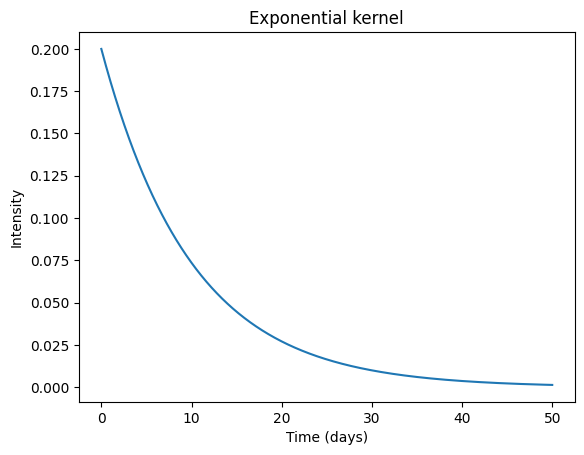

In [21]:
time50 = np.linspace(0,50,10000)
kernel_intensity = [exponential_kernel(t, 0, 0.2, 0.1) for t in time50]
plt.plot(time50, kernel_intensity)
plt.xlabel("Time (days)")
plt.ylabel("Intensity")
plt.title("Exponential kernel")

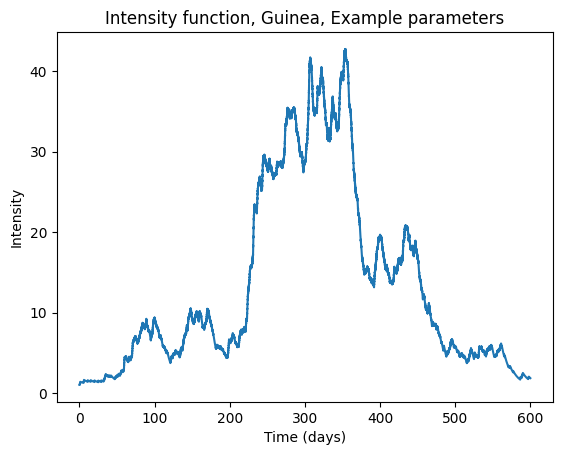

In [65]:
def intensity_plot(T):
    time = np.arange(0,T,0.01)
    kernel_intensity = [intensity(t, observed_guinea, 0.2, 0.1, 1) for t in time]
    plt.plot(time, kernel_intensity)
    plt.xlabel("Time (days)")
    plt.ylabel("Intensity")
    plt.title("Intensity function, Guinea, Example parameters")

intensity_plot(600)

## MLE Estimation

In [80]:
def loglikelihood_terms(parameters, event_times, T):
    #Get event times up to T
    def event_times_small(event_times, T):
        end = binary_search(event_times,T)
        return event_times[:end]
    event_times_t = event_times_small(event_times, T)

    #Integral term of log likelihood
    def integral_slices(parameters, events):
        alpha, delta, mu = parameters
        integral_slices = []
        integral_intervals = [0] + events + [T]
        for ind in range(len(integral_intervals)-1):
            i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])
            integral_slices.append(i[0])
        return integral_slices

    integral_slices_t = integral_slices(parameters, event_times_t)

    #log term of log likelihood
    def log_term(parameters, events):
        alpha, delta, mu = parameters
        log_terms = []
        for t_i in events:
            log_terms.append(np.log(intensity(t_i, event_times_t, alpha, delta, mu)))
        return log_terms
    log_terms_t = log_term(parameters, event_times_t)

    return integral_slices_t, log_terms_t
        
example_parameters = [0.2,0.1,1]
y2, y3  = loglikelihood_terms(example_parameters, observed_guinea, 200)
print(y2)
print(y3)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\112472297.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])


[0.5, 0.5975411509985721, 5.914141226332616, 0.7188978334811453, 7.466824468436233, 5.912999358219149, 7.317375437936717, 7.192497933748342, 5.773586696091546, 4.453008276302867, 1.5855475113262167, 0.8690752369615127, 0.9486163762509361, 1.0242782484013457, 1.0962500475036265, 6.532481827089792, 4.192792032403807, 4.157844765877403, 9.621785922441981, 1.8683067586890472, 1.9760016095234514, 2.0734479402882213, 3.19835622450288, 1.1087246381566993, 4.514687843884905, 1.151476315883021, 1.2172445920318236, 1.2798053115032526, 1.338657681576753, 4.0551510336419465, 1.3675647522925305, 3.0709355938927643, 0.28855755867959804, 0.30658171212452756, 0.3244265222461929, 0.3420937735404112, 0.3595852327470572, 0.3769026490266271, 0.39404775413515275, 0.41102226259751634, 0.427827871878625, 2.1883956952392105, 2.2035928165104495, 2.217391538325699, 2.2311745156425222, 8.483115640071327, 3.9768759215040936, 0.9979034669155166, 1.0288178404663924, 1.0589689354147078, 1.0883755971763072, 4.3418798

In [81]:
def loglikelihood(parameters, event_times, T):
    integral_slices_t, log_terms_t = loglikelihood_terms(parameters, event_times, T)
    integral_term = np.sum(integral_slices_t)
    log_sum = np.sum(log_terms_t)
    print(integral_term)
    print(log_sum)
    return integral_term - log_sum

loglikelihood(example_parameters, observed_guinea, 200)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\112472297.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])


1070.5122670232095
857.8943178799605


212.617949143249